## Hollowings
This notebook shows how a _hollowing_ (lavning) is computed. 

The goal is to be able to determine if a house is located in a hollwoing and thus 
has an increased risk of flooding if heavy rain occurs. 

We can achive this by using the _danish height model_ data set from [kortforsyningen](https://kortforsyningen.dk/indhold/webservice-liste-0). The data set is served in the [wms](https://en.wikipedia.org/wiki/Web_Map_Service) format. The data is returned as images where the pixal value for instance can indicate how big a hollowing is. 

We split the task into the following steps.
1. *Adress lookup:* We must be able to convert an adress of the form `Kjærmarken 103, 6771 gredstedbro` into a set of longtitude and latitude. 
2. *Image retrival:* Using the longtitude and latitude we retrive the relevant images and convert them to a useable format
3. *Compute the risk:* We use the image to compute the risk of flooding. 
4. *Construct final image:* To add transparency we combine the data images with a proper map and prepare an image that ilustrates the computation and can be shown to the end user. 

> The notebook is written with test driven development, thus each code cell contains an assertion 

### Address lookup
We start by creating functions that can convert text adresses to coordinates, we use the [Dawa API](https://dawa.aws.dk/dok/api) to perform the lookups

In [5]:
import requests
import json
def addressToLatLong(address):
    response = requests.request(
        "GET", 
        "https://dawa.aws.dk/adgangsadresser", 
        params={"q": address,"struktur":"mini"}
    )
    data = json.loads(response.content)[0]
    return data['x'], data['y']

x, y = addressToLatLong("Kjærmarken 103, 6771 Gredstedbro")
assert x == 8.74228813
assert y == 55.40156089

#### Bouding box
To be able to retrive an image from a [WMS api](https://docs.geoserver.org/stable/en/user/services/wms/reference.html) with a langtitude and latitude pair we must compute a bounding box of the format `minx,miny,maxx,maxy`.

Dawa uses the [EPSG:4326](https://epsg.io/4326) projection which corrosponds to standard GPS coordinates. The WMS Api uses the [ESPG spatial refrence system](https://en.wikipedia.org/wiki/Spatial_reference_system), specifically the [EPSG:3857](https://epsg.io/3857) projection wich uses meters as units. 

We want to be able to specify a bounding box that has the latitude and longtidue as center of the box and then specify how many meters the box should extend in each direction. 

The steps of computing the bounding box is thus.
1. Convert from langtitude lotitude to EPSG:3857 projection. 
2. Create a box that has the specifyed with and height with the point in the center. 



In [6]:
from pyproj import Proj, transform
def convertEPSG(x, y):
    return transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), x, y)

x, y = addressToLatLong("Kjærmarken 103, 6771 Gredstedbro")
x, y = convertEPSG(x, y)
print(x,y)
assert x == 973187.0629996799
assert y == 7440194.196982217

973187.0629996799 7440194.196982217


In [7]:
def boundingBox(x, y, boxSize=200):
    minx = x - boxSize / 2
    miny = y - boxSize / 2
    maxx = x + boxSize / 2
    maxy = y + boxSize / 2
    return f'{minx},{miny},{maxx},{maxy}'

assert boundingBox(0,0, boxSize=2) == '-1.0,-1.0,1.0,1.0'

In [40]:
from PIL import Image
from io import BytesIO
def getImg(x, y, feature, mode="L"):
    params = {
        "service": "WMS",
        "login": "rotendahl",
        "password": os.environ['KORTFORSYNINGEN_KEY'],
        "TRANSPARENT": "True",
        "VERSION": "1.1.1",
        "REQUEST": "GetMap",
        "FORMAT": "image/png",
        "SRS": "EPSG:3857",
        "BBOX": boundingBox(x,y),
        "WIDTH": "400",
        "HEIGHT": "400",
    }
    if feature == 'buildings':
        params["LAYERS"] = "BU.Building"
        params["servicename"] = "building_inspire"
  
    elif feature == 'hollowings':
        params["servicename"] = "dhm",
        params["LAYERS"] = "dhm_bluespot_ekstremregn"
        params["STYLES"] = "bluespot_ekstremregn_0_015"
    
    response = requests.request(
        "GET",
        "https://kortforsyningen.kms.dk/",
        params=params
    )
    img = Image.open(BytesIO(response.content))
    return img.convert(mode)

img = getImg(973187.0629996799,7440194.196982217, 'buildings')
assert img.size == (400,400)

In [41]:
# Combines the previous functions
def addressToImages(address):
    x,y = addressToLatLong(address)
    x,y = convertEPSG(x, y)
    return getImg(x, y, 'buildings'), getImg(x, y, 'hollowings') 
    
buildImg, hollowImg = addressToImages('kjærmarken 103, 6771 gredstedbro')

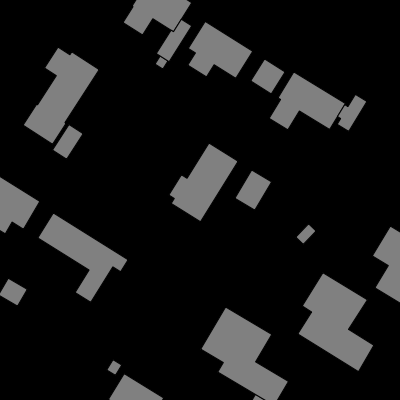

In [42]:
buildImg

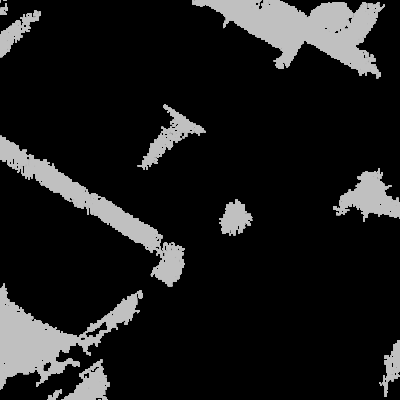

In [43]:
hollowImg

### Handeling the images
We are now able to retrive the requried data for 

In [39]:
pd.DataFrame(np.asarray(hollowImg))

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,True,False,False,True,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,True,True,True,False,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
8,True,True,False,True,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,True,True,True,True,False,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
